## 1. Load the packages

In [1]:
# Data processing packages
import numpy as np
import pandas as pd
from collections import Counter

# Machine learning packages
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE, SelectPercentile, chi2, mutual_info_regression, SelectFromModel
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

import torch

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# Others
import time
from pathlib import Path

## 2. Read the data

In [ ]:
X1 = pd.read_csv("X1.csv")
Y1 = pd.read_csv("Y1.csv", header=None, names=['revenue '])
X2 = pd.read_csv("X2.csv")

In [ ]:
X1

## 3. Data Preprocessing

### STEP 1: Data Cleaning (columns drop off and missing value processing)

In [ ]:
def data_cleaning_process(df):
    """
    This function will drop columns, like "Unnamed: 0", "title", "img_url", "description" from the dataset, and replace the missing value in `runtime` column with a median value, and replace the missing value in `genres` with "Others".
    :param df: A dataframe (X1 or X2)
    :return: A new cleaned dataframe
    """

    new_df = df.copy()
    # missing value for runtime: replace "\\N" with median value
    median_runtime = np.median(new_df.loc[new_df['runtime'] != '\\N', 'runtime'].astype(np.int64))
    new_df['runtime'] = np.where(new_df['runtime'] == '\\N', median_runtime, new_df['runtime']).astype(np.int64)

    # missing value for genres: replace "\\N" with "Others"
    new_df.loc[new_df['genres'] == "\\N", "genres"] = "Others"

    # drop "Unnamed: 0", "title", "img_url", "description"
    new_df = new_df.drop(["Unnamed: 0", "title", "img_url", "description"], axis=1)

    return new_df

In [ ]:
X1_cleaned = data_cleaning_process(X1)

### STEP 2: Data Type Split (Numerical, Categorical, Embeddings)

In [ ]:
def data_type_split(df):
    """
    This function will split the whole dataset into different sub dataset according to the data types of the columns
    :param df: A dataframe
    :return: three datadrames, which are numerical, categorical, embeddings
    """

    new_df = df.copy()
    numeric_features = new_df.select_dtypes(include="number").columns.tolist()
    non_numeric_features = new_df.select_dtypes(exclude="number").columns.tolist()
    embedding_features = ['img_embeddings', 'text_embeddings']
    numeric_features.remove('is_adult')
    categorical_features = non_numeric_features.copy()
    [categorical_features.remove(col) for col in embedding_features]
    categorical_features.append('is_adult')
    return new_df.loc[:, numeric_features], new_df.loc[:, categorical_features], new_df.loc[:, embedding_features]

In [ ]:
df_num, df_cat, df_emb = data_type_split(X1_cleaned)

In [ ]:
df_num.head()

In [ ]:
df_cat.head()

In [ ]:
df_emb.head()

### STEP 3: Categorical Columns Processing (Genres --> multilable binary type, Studio --> studio_frequency)

In [ ]:
dict_cat_freq = torch.load("studio_freq")

In [ ]:
mlb = MultiLabelBinarizer()
df_cat['genres_split'] = df_cat['genres'].apply(lambda x: x.split(","))
mlb.fit(df_cat['genres_split'])

In [ ]:
def categorical_process(df):
    """
    This function will process on `genres` and `studio` columns.
    `genres` will be transformed to multilabel binary variables;
    `studio` will be transformed to a frequency type.
    :param df: A categorical datframe
    :return: A new dataframe
    """

    new_df = df.copy()

    # processing on `genres` column
    new_df['genres_split'] = new_df['genres'].apply(lambda x: x.split(","))
    # mlb = MultiLabelBinarizer()
    genere_encoder_df = pd.DataFrame(mlb.transform(new_df['genres_split']))
    genere_encoder_df.columns = mlb.classes_.tolist()

    # processing on `studio` column
    studio_freq_df = pd.DataFrame(new_df['studio'].apply(lambda x: dict_cat_freq[x] if x in dict_cat_freq.keys() else min(dict_cat_freq.values())))
    studio_freq_df.columns = ['studio_freq']


    processed_cat_df = pd.concat([genere_encoder_df, studio_freq_df, new_df['is_adult']], axis=1)

    return processed_cat_df

In [ ]:
categorical_process(df_cat).columns

### STEP 4: Embedding Column Processing

In [ ]:
def listToDF(df, column_name):

    new_df = []
    for row in df[column_name]:
        ls = []
        row = eval(row)
        for each in row:
            ls.append(each)
        new_df.append(ls)

    new_df = pd.DataFrame(new_df)

    return new_df

In [ ]:
def embedding_process(df):
    new_df = df.copy()

    # image embeddings
    img_emb_df = listToDF(new_df, 'img_embeddings')
    text_emb_df = listToDF(new_df, 'text_embeddings')

    processed_emb_df = pd.concat([img_emb_df, text_emb_df], axis=1)
    return processed_emb_df

In [ ]:
embedding_process(X1.loc[:, ['img_embeddings', 'text_embeddings']])

### STEP 5: Combine Everything

In [ ]:
def data_combine(df_num, df_cat, df_emb):
    new_df = pd.concat([df_num, df_cat, df_emb], axis=1)
    return new_df

In [ ]:
df_processed = data_combine(df_num, categorical_process(df_cat), df_emb)

In [ ]:
df_processed

### STEP 6: Normalization and Standarization

In [ ]:
def data_scaling(df):
    """
    This function will process on the numercial columns.
    For `ratings`, we will use normalization
    For the other columns, we will use standardization
    :param df:
    :return:
    """
    new_X = df.copy().to_numpy()
    # new_df = df.copy()

    # df_norm = new_df["ratings"]
    # df_stad = new_df.iloc[:, 1:]
    scaler_norm = MinMaxScaler().fit(new_X[:, 0].reshape([-1, 1]))
    scaler_stad = StandardScaler().fit(new_X[:, 1:5])
    new_X[:, 0] = scaler_norm.transform(new_X[:, 0].reshape([-1, 1])).ravel()
    new_X[:, 1:5] = scaler_stad.transform(new_X[:, 1:5])

    return new_X

In [ ]:
data_scaling(df_processed)

### Construct Data Engineering Pipeline

In [ ]:
def DataEngineering(df):
    df_cleaned = data_cleaning_process(df)
    df_num, df_cat, df_emb = data_type_split(df_cleaned)
    df_cat_processed = categorical_process(df_cat)
    df_emb_processed = embedding_process(df_emb)
    df_processed = data_combine(df_num, df_cat_processed, df_emb_processed)
    X_ready = data_scaling(df_processed)

    return X_ready

In [ ]:
preprocess_transformer = FunctionTransformer(DataEngineering)

In [ ]:
p1 = Pipeline([
    ('Preprocessor', preprocess_transformer)
])

In [ ]:
X1_pre = p1.fit_transform(X1)
X1_pre[:5, :]

## 4. Feature Selection

### 4.1 Give the column names to the dataset

In [ ]:
def renamingDataset(X):
    new_X = X.copy()
    new_df = pd.DataFrame(new_X)
    num_col_names = ['ratings', 'n_votes', 'production_year', 'runtime', 'release_year']
    cat_col_names = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Others',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western', 'studio_freq', 'is_adult']
    img_emb_names = []
    for i in range(2048):
        img_emb_names.append("img_emb_" + str(i))

    text_emb_names = []
    for i in range(768):
        text_emb_names.append("text_emb_" + str(i))

    all_col_names = num_col_names + cat_col_names + img_emb_names + text_emb_names

    new_df.columns = all_col_names

    return new_df

In [ ]:
renamed_df_ready = renamingDataset(X1_pre)
renamed_df_ready.head()

In [ ]:
def divideDataset(df):
    new_df = df.copy()

    non_emb_df = new_df.iloc[:, :34]
    img_emb_df = new_df.iloc[:, 34:2082]
    text_emb_df = new_df.iloc[:, 2082:]

    return non_emb_df, img_emb_df, text_emb_df # pd.dataframe type

In [ ]:
non_emb_df, img_emb_df, text_emb_df = divideDataset(renamed_df_ready)

### 4.2 DR on Embeddings

#### 4.2.1 Implement PCA for reducing the embedding features

In [ ]:
scaler_emb = MinMaxScaler()
emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))
pca_emb = PCA(n_components=0.9)
pca_emb.fit(emb_df_scaled)

def DRembeddings_pca(img_emb_df, text_emb_df):

    # scale the data to the range between 0 and 1 before using PCA
    # scaler_emb = MinMaxScaler()
    # img_emb_df_scaled = scaler_emb.fit_transform(img_emb_df)
    # text_emb_df_scaled = scaler_emb.fit_transform(text_emb_df)
    emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

    # pca_emb = PCA(n_components=n_components)
    # df_reduced_emb = pd.DataFrame(pca_emb.fit_transform(emb_df_scaled))
    df_reduced_emb = pd.DataFrame(pca_emb.transform(emb_df_scaled))

    emb_col_names = []
    for i in range(df_reduced_emb.shape[1]):
        emb_col_names.append("emb_" + str(i))

    df_reduced_emb.columns = emb_col_names

    return df_reduced_emb

In [ ]:
df_reduced_emb_pca = DRembeddings_pca(img_emb_df, text_emb_df)
df_reduced_emb_pca.head()

#### 4.2.2 tSNE for reducing the embedding features

In [ ]:
scaler_emb = MinMaxScaler()
emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

def DRembeddings_tsne(img_emb_df, text_emb_df, n_components=2, perplexity=50):

    # scale the data to the range between 0 and 1 before using PCA
    # scaler_emb = MinMaxScaler()
    # img_emb_df_scaled = scaler_emb.fit_transform(img_emb_df)
    # text_emb_df_scaled = scaler_emb.fit_transform(text_emb_df)
    emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

    # pca_emb = PCA(n_components=n_components)
    tsne_emb = TSNE(n_components=n_components, perplexity=perplexity, init='pca', learning_rate='auto', random_state=42)
    df_reduced_emb = pd.DataFrame(tsne_emb.fit_transform(emb_df_scaled))

    emb_col_names = []
    for i in range(df_reduced_emb.shape[1]):
        emb_col_names.append("emb_" + str(i))

    df_reduced_emb.columns = emb_col_names

    return df_reduced_emb

In [ ]:
df_reduced_emb_tsne = DRembeddings_tsne(img_emb_df, text_emb_df)
df_reduced_emb_tsne.head()

#### 4.2.3 ICA for reducing the embedding features

In [ ]:
scaler_emb = MinMaxScaler()
emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

def DRembeddings_ica(img_emb_df, text_emb_df, n_components=2):

    # scale the data to the range between 0 and 1 before using PCA
    # scaler_emb = MinMaxScaler()
    # img_emb_df_scaled = scaler_emb.fit_transform(img_emb_df)
    # text_emb_df_scaled = scaler_emb.fit_transform(text_emb_df)
    emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

    # pca_emb = PCA(n_components=n_components)
    ica_emb = FastICA(n_components=n_components, random_state=42, whiten='unit-variance')
    df_reduced_emb = pd.DataFrame(ica_emb.fit_transform(emb_df_scaled))

    emb_col_names = []
    for i in range(df_reduced_emb.shape[1]):
        emb_col_names.append("emb_" + str(i))

    df_reduced_emb.columns = emb_col_names

    return df_reduced_emb

In [ ]:
df_reduced_emb_ica = DRembeddings_ica(img_emb_df, text_emb_df, n_components=199)
df_reduced_emb_ica.head()

### 4.3 Feature Selection

We will predict the log(1 + Y1)

In [ ]:
"""
    The forward feature selection takes a bit time, so we saved the feature selection reulst into a file using torch
"""
np.random.seed(42)
rfr = RandomForestRegressor(n_jobs=-1)
sfs_34features = SequentialFeatureSelector(
    rfr,
    k_features=34,
    forward=True,
    floating=False,
    verbose=2,
    scoring='neg_mean_squared_error',
    cv=10,
).fit(non_emb_df, np.log(1 + Y1.to_numpy().ravel()))


In [ ]:
if Path('../models').exists():
    torch.save(sfs_34features, "../models/foward_feature_selection_34features")
else:
    Path('../model').mkdir(parents=True, exist_ok=True)
    torch.save(sfs_34features, "../models/foward_feature_selection_34features")

In [ ]:
# Load the feature selection result
sfs_34 = torch.load("../models/foward_feature_selection_34features")

In [ ]:
sfs_result = pd.DataFrame.from_dict(sfs_34.get_metric_dict()).T
sfs_result

In [ ]:
fig1 = plot_sfs(sfs_34.get_metric_dict(), kind='std_dev')
# plt.title('Forward Feature Selection (w. StdDev)')
plt.grid()
plt.savefig('../Figures/foward_selection.pdf')
plt.show()

In [ ]:
sfs_34.k_score_

In [ ]:
sfs_34.k_feature_idx_

In [ ]:
np.argmax(sfs_result.loc[:, 'avg_score'])

In [ ]:
features_selected = list(sfs_result.iloc[27, :]['feature_names'])
non_emb_df_selected = non_emb_df[features_selected]
non_emb_df_selected.head()

### 4.4 Combine selected non_emb with reduced emb

In [ ]:
def combineNonReducedEmb(non_emb_df_selected, reduced_emb_df):
    DR_df = pd.concat([non_emb_df_selected, reduced_emb_df], axis=1)
    return DR_df

In [ ]:
DR_df = combineNonReducedEmb(non_emb_df_selected, df_reduced_emb_pca)
DR_df.head()

### Construct Feature Selection Pipeline

In [ ]:
def FeatureSelection(X, dr_method, n_components=2, perplexity=50):
    renamed_df_ready = renamingDataset(X)
    non_emb_df, img_emb_df, text_emb_df = divideDataset(renamed_df_ready)
    if dr_method == "pca":
        reduced_emb_df = DRembeddings_pca(img_emb_df, text_emb_df)
    elif dr_method == "tsne":
        reduced_emb_df = DRembeddings_tsne(img_emb_df, text_emb_df, n_components=n_components, perplexity=perplexity)
    elif dr_method == 'ica':
        reduced_emb_df = DRembeddings_ica(img_emb_df, text_emb_df, n_components=n_components)
    non_emb_df_selected = non_emb_df[features_selected]
    DR_df = combineNonReducedEmb(non_emb_df_selected, reduced_emb_df)

    return DR_df

In [ ]:
feature_selection_transformer_pca = FunctionTransformer(FeatureSelection, kw_args={'dr_method':'pca'})
feature_selection_transformer_tsne = FunctionTransformer(FeatureSelection, kw_args={'dr_method':'tsne', 'n_components':3, 'perplexity':100})

In [ ]:
p2_pca = Pipeline([
    ('Preprocessor', preprocess_transformer),
    ('FeatureSelectionPCA', FunctionTransformer(FeatureSelection, kw_args={'dr_method':'pca'})),
])

p2_tsne = Pipeline([
    ('Preprocessor', preprocess_transformer),
    ('FeatureSelectionTSNE', FunctionTransformer(FeatureSelection, kw_args={'dr_method':'tsne', 'n_components':3, 'perplexity':100})),
])

p2_ica = Pipeline([
    ('Preprocessor', preprocess_transformer),
    ('FeatureSelectionICA', FunctionTransformer(FeatureSelection, kw_args={'dr_method':'ica', 'n_components':199})),
])

In [ ]:
X1_pca = p2_pca.fit_transform(X1)
torch.save(X1_pca, "X1_pca")
X1_pca.head()

In [ ]:
X1_tsne = p2_tsne.fit_transform(X1)
torch.save(X1_tsne, "X1_tsne")
X1_tsne.head()

In [ ]:
X1_ica = p2_ica.fit_transform(X1)
torch.save(X1_ica, "X1_ica")
X1_ica.head()

## 5. Models

In [2]:
X1_pca = torch.load('X1_pca').to_numpy()
X1_ica = torch.load('X1_ica').to_numpy()
X1_tsne = torch.load('X1_tsne').to_numpy()
Y1 = pd.read_csv("Y1.csv", header=None, names=['revenue ']).to_numpy().ravel()

In [3]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X1_pca, Y1, random_state=42, test_size=0.1)
X_train_ica, X_test_ica, _, _ = train_test_split(X1_ica, Y1, random_state=42, test_size=0.1)
X_train_tsne, X_test_tsne, _, _ = train_test_split(X1_tsne, Y1, random_state=42, test_size=0.1)

### 5.1 Linear regression

In [4]:
LR_pca = LinearRegression()
LR_ica = LinearRegression()
LR_tsne = LinearRegression()

In [5]:
# # np.random.seed(42)
# scores = cross_val_score(LR_model_pca, X_train_pca, np.log(1 + y_train), scoring='r2', cv=10)
# print("R^2 of the Linear Regression based on the PCA embeddings: {:.6} %".format(scores.mean()*100))
# scores = cross_val_score(LR_model_pca, X_train_pca, np.log(1 + y_train), scoring='neg_root_mean_squared_error', cv=10)
# print("RMSE of the Linear Regression based on the PCA embeddings: {:.4}".format(scores.mean()))

In [6]:
# scores = cross_val_score(LR_model_ica, X_train_ica, np.log(1 + y_train), scoring='r2', cv=10)
# print("R^2 of the Linear Regression based on the ICA embeddings: {:.6} %".format(scores.mean()*100))
# scores = cross_val_score(LR_model_ica, X_train_ica, np.log(1 + y_train), scoring='neg_root_mean_squared_error', cv=10)
# print("RMSE of the Linear Regression based on the ICA embeddings: {:.4} ".format(scores.mean()))

In [7]:
LR_pca.fit(X_train_pca, np.log(1 + y_train))
y_pred_LR_pca = np.exp(LR_pca.predict(X_test_pca)) - 1
print("Root mean squared error (PCA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_LR_pca))/1000000))
# r2_score(y_test, y_pred_LR_pca)

Root mean squared error (PCA Embeddings): 1478.50 Millions


In [8]:
LR_ica.fit(X_train_ica, np.log(1 + y_train))
y_pred_LR_ica = np.exp(LR_ica.predict(X_test_ica)) - 1
print("Root mean squared error (ICA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_LR_ica)) / 1000000))

Root mean squared error (ICA Embeddings): 1462.45 Millions


In [9]:
LR_tsne.fit(X_train_tsne, np.log(1 + y_train))
y_pred_LR_tsne = np.exp(LR_tsne.predict(X_test_tsne)) - 1
print("Root mean squared error (tSNE Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_LR_tsne))/1000000))

Root mean squared error (tSNE Embeddings): 1261.71 Millions


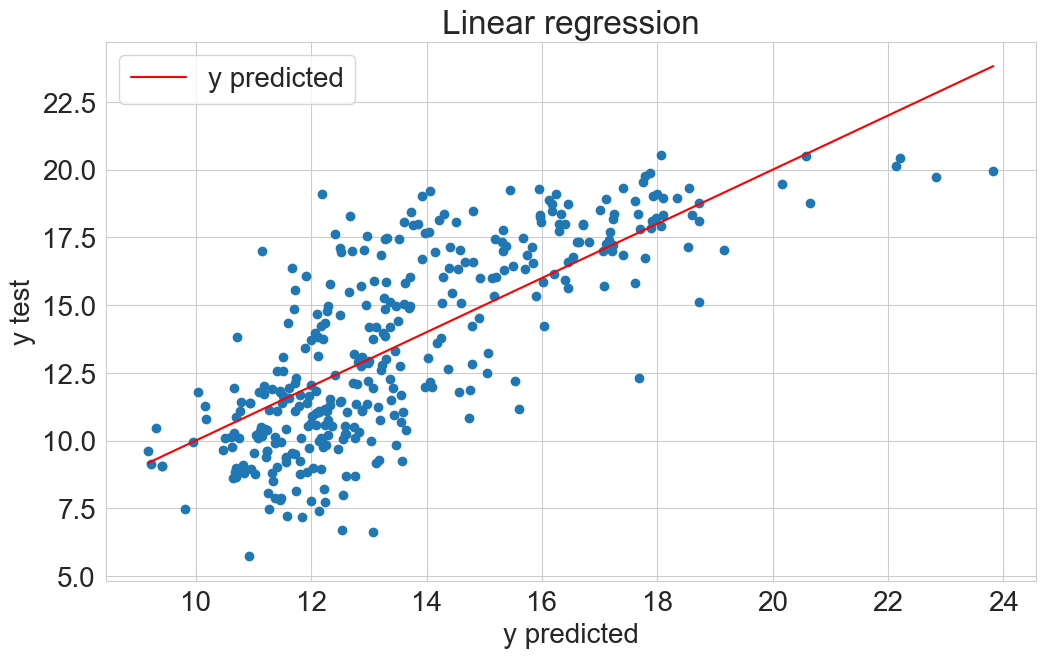

In [10]:
plt.rc("font", size=20)
plt.figure(figsize=(12,7))
plt.title('Linear regression')
plt.xlabel("y predicted")
plt.ylabel("y test")
plt.plot(np.log(y_pred_LR_tsne), np.log(y_test),'o')
plt.plot(np.linspace(np.min(np.log(y_pred_LR_tsne)),np.max(np.log(y_pred_LR_tsne)),2),np.linspace(np.min(np.log(y_pred_LR_tsne)),np.max(np.log(y_pred_LR_tsne)),2), label="y predicted",color="red")
plt.legend()

### 5.2 KNN

In [17]:
knn = KNeighborsRegressor()
knn_k_range = list(range(1, 41))
knn_param_grid = {
    'n_neighbors': knn_k_range
}

In [18]:
knn_grid_pca = GridSearchCV(knn, knn_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
knn_grid_ica = GridSearchCV(knn, knn_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
knn_grid_tsne = GridSearchCV(knn, knn_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)

In [19]:
## Model selection
# knn_grid_pca.fit(X_train_pca, np.log(1 + y_train))
# knn_grid_ica.fit(X_train_ica, np.log(1 + y_train))
# knn_grid_tsne.fit(X_train_tsne, np.log(1 + y_train))

## Save the model selection results
# torch.save(knn_grid_pca, '../models/knn_grid_pca')
# torch.save(knn_grid_ica, '../models/knn_grid_ica')
# torch.save(knn_grid_tsne, '../models/knn_grid_tsne')

## Load the results
knn_grid_pca = torch.load('../models/knn_grid_pca')
knn_grid_ica = torch.load('../models/knn_grid_ica')
knn_grid_tsne = torch.load('../models/knn_grid_tsne')

In [24]:
print("[knn_grid_pca] The best parameter K is:", knn_grid_pca.best_params_)
print("[knn_grid_pca] The best RMSE is:", knn_grid_pca.best_score_)
print()
print("[knn_grid_ica] The best parameter K is:", knn_grid_ica.best_params_)
print("[knn_grid_ica] The best RMSE is:", knn_grid_ica.best_score_)
print()
print("[knn_grid_tsne] The best parameter K is:", knn_grid_tsne.best_params_)
print("[knn_grid_tsne] The best RMSE is:", knn_grid_tsne.best_score_)

[knn_grid_pca] The best parameter K is: {'n_neighbors': 22}
[knn_grid_pca] The best RMSE is: -2.9175044373092835

[knn_grid_ica] The best parameter K is: {'n_neighbors': 13}
[knn_grid_ica] The best RMSE is: -2.5662457263191483

[knn_grid_tsne] The best parameter K is: {'n_neighbors': 12}
[knn_grid_tsne] The best RMSE is: -3.24501342188343


In [25]:
knn_grid_ica.cv_results_

{'mean_fit_time': array([0.00166638, 0.00181937, 0.00144291, 0.00183141, 0.00130978,
        0.00158269, 0.00156178, 0.00159557, 0.00137258, 0.00138652,
        0.00157666, 0.00232878, 0.00127811, 0.00140305, 0.00205228,
        0.00141797, 0.00133142, 0.00130665, 0.00157607, 0.00126796,
        0.00142775, 0.00134478, 0.00139878, 0.00137756, 0.00128474,
        0.00161676, 0.00144441, 0.00128818, 0.00145438, 0.0014478 ,
        0.00136271, 0.00139809, 0.00142486, 0.00131814, 0.00131304,
        0.00146976, 0.00146518, 0.00126913, 0.00123951, 0.0014806 ]),
 'std_fit_time': array([3.40235292e-04, 5.14408116e-04, 2.52818818e-04, 4.77451373e-04,
        1.59315077e-04, 4.69406852e-04, 3.80521433e-04, 5.25550136e-04,
        1.81547318e-04, 2.16160525e-04, 4.63528837e-04, 1.71800472e-03,
        1.56065305e-04, 3.26339924e-04, 6.87919728e-04, 2.82120780e-04,
        2.53279794e-04, 1.48772974e-04, 5.46477105e-04, 2.34310735e-04,
        2.60402977e-04, 2.53694200e-04, 2.45599131e-04, 1.489

In [31]:
def plot_rmse_line(grid_search_list, label_list, fig_name):

    plt.figure(figsize=(16, 8))

    for i in range(len(grid_search_list)):
        grid_search = grid_search_list[i]
        cv_result = grid_search.cv_results_
        mean_test_score = np.abs(cv_result['mean_test_score'])
        min_x = np.argmin(mean_test_score) + 1
        min_y = np.min(mean_test_score)

        plt.plot(mean_test_score, label=label_list[i])
        if i == len(grid_search_list) - 1:
            plt.scatter(min_x, min_y, c='r', marker='x', label='minimum')
        else:
            plt.scatter(min_x, min_y, c='r', marker='x')

    plt.legend()
    plt.xlabel('K neighbours')
    plt.ylabel('RMSE')
    plt.savefig('../Figures/' + fig_name)
    plt.show()

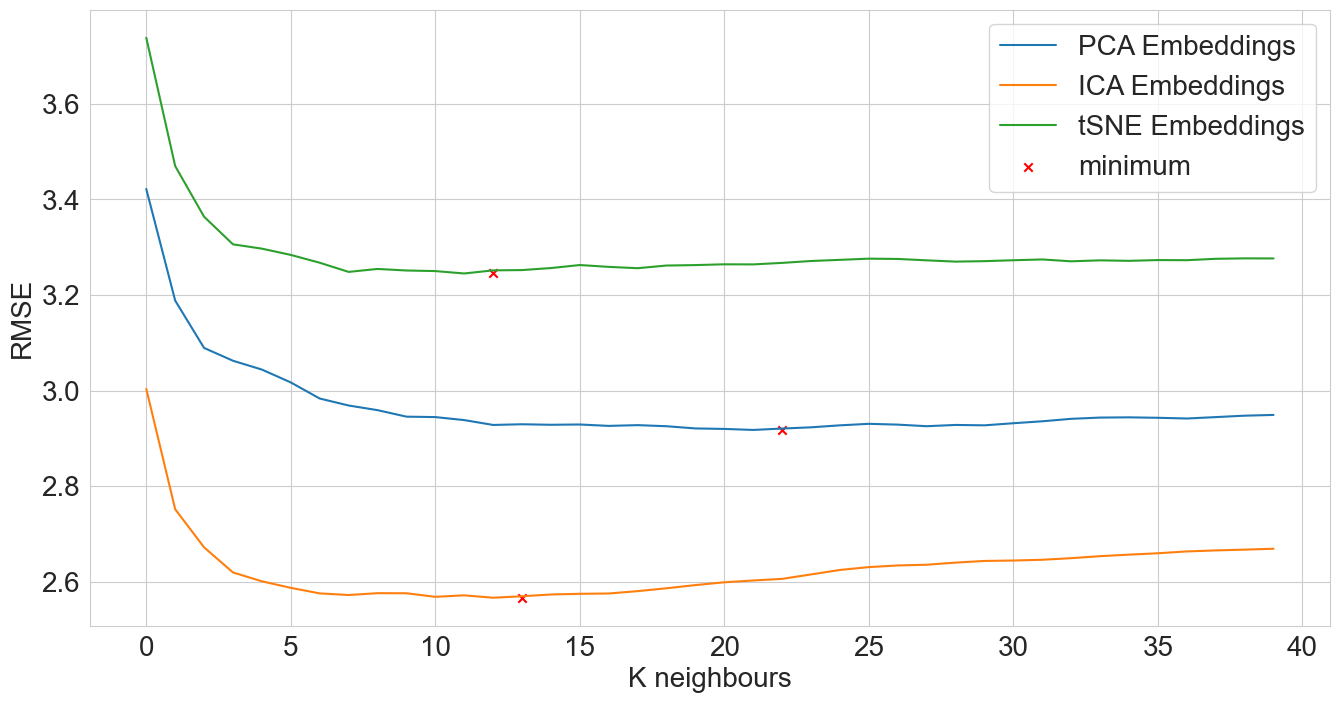

In [32]:
grid_search_list = [knn_grid_pca, knn_grid_ica, knn_grid_tsne]
label_list = ['PCA Embeddings', 'ICA Embeddings', 'tSNE Embeddings']
plot_rmse_line(grid_search_list, label_list, 'KNN_model_selection.pdf')

#### Use the best K parameters

In [33]:
knn_22 = KNeighborsRegressor(n_neighbors=22) # PCA
knn_13 = KNeighborsRegressor(n_neighbors=13) # ICA
knn_12 = KNeighborsRegressor(n_neighbors=12) # TSNE

In [39]:
knn_22.fit(X_train_pca, np.log(1 + y_train))
y_pred_knn_22_pca = np.exp(knn_22.predict(X_test_pca)) - 1
print("Root mean squared error (PCA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_knn_22_pca))/1000000))
print("R-square (PCA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_knn_22_pca)*100))

Root mean squared error (PCA Embeddings): 92.45 Millions
Root mean squared error (PCA Embeddings): 14.28 %


In [43]:
knn_13.fit(X_train_ica, np.log(1 + y_train))
y_pred_knn_13_ica = np.exp(knn_13.predict(X_test_ica)) - 1
print("Root mean squared error (ICA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_knn_13_ica))/1000000))
print("R-square (ICA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_knn_13_ica)*100))

Root mean squared error (ICA Embeddings): 82.24 Millions
Root mean squared error (ICA Embeddings): 32.18 %


In [44]:
knn_12.fit(X_train_tsne, np.log(1 + y_train))
y_pred_knn_12_ica = np.exp(knn_12.predict(X_test_tsne)) - 1
print("Root mean squared error (TSNE Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_knn_12_ica))/1000000))
print("R-square (TSNE Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_knn_12_ica)*100))

Root mean squared error (TSNE Embeddings): 104.16 Millions
Root mean squared error (TSNE Embeddings): -8.79 %


### 5.3 MLP

In [48]:
mlp = MLPRegressor(random_state=42, max_iter=1000, verbose=0)
hidden_layer_lists = [
    (200,),
    (200, 175,),
    (200, 175, 150,),
    (200, 175, 150, 125,),
    (200, 175, 150, 125, 100,),
    (200, 175, 150, 125, 100, 75,),
    (200, 175, 150, 125, 100, 75, 50,),
    (200, 175, 150, 125, 100, 75, 50, 25,),
    (200, 175, 150, 125, 100, 75, 50, 25, 10)
]
mlp_parameter_grid = {
    'hidden_layer_sizes': hidden_layer_lists,
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'batch_size': [177],
    'learning_rate': ['constant','adaptive'],
}

In [49]:
mlp_grid_pca = GridSearchCV(mlp, mlp_parameter_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
mlp_grid_ica = GridSearchCV(mlp, mlp_parameter_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
mlp_grid_tsne = GridSearchCV(mlp, mlp_parameter_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)

In [50]:
## Find the best parameters for mlp regressor using three different features
# mlp_grid_pca.fit(X_train_pca, np.log(1 + y_train))
# mlp_grid_ica.fit(X_train_ica, np.log(1 + y_train))
# mlp_grid_tsne.fit(X_train_tsne, np.log(1 + y_train))

## Save the grid search results
# torch.save(mlp_grid_pca, "../models/mlp_grid_pca")
# torch.save(mlp_grid_ica, "../models/mlp_grid_ica")
# torch.save(mlp_grid_tsne, "../models/mlp_grid_tsne")

In [22]:
## Load the model selection results
mlp_grid_pca = torch.load("../models/mlp_grid_pca")
mlp_grid_ica = torch.load("../models/mlp_grid_ica")
mlp_grid_tsne = torch.load("../models/mlp_grid_tsne")

In [53]:
print("[mlp_grid_pca] The best parameters are:", mlp_grid_pca.best_params_)
print("[mlp_grid_pca] The best RMSE is:", mlp_grid_pca.best_score_)
print()
print("[mlp_grid_ica] The best parameters are:", mlp_grid_ica.best_params_)
print("[mlp_grid_ica] The best RMSE is:", mlp_grid_ica.best_score_)
print()
print("[mlp_grid_tsne] The best parameters are:", mlp_grid_tsne.best_params_)
print("[mlp_grid_tsne] The best RMSE is:", mlp_grid_tsne.best_score_)

[mlp_grid_pca] The best parameters are: {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 177, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'solver': 'adam'}
[mlp_grid_pca] The best RMSE is: -2.366255956054574

[mlp_grid_ica] The best parameters are: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 177, 'hidden_layer_sizes': (200,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
[mlp_grid_ica] The best RMSE is: -2.189728879932728

[mlp_grid_tsne] The best parameters are: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 177, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'solver': 'adam'}
[mlp_grid_tsne] The best RMSE is: -2.2697205948344994


#### Use the best parameters for MLP regressor

In [24]:
mlp_pca = MLPRegressor(
    hidden_layer_sizes=(200,),
    learning_rate='constant',
    solver='adam',
    activation='tanh',
    alpha=0.0001,
    batch_size=177,
    random_state=42, max_iter=1000, verbose=0
)

mlp_ica = MLPRegressor(
    hidden_layer_sizes=(200,),
    learning_rate='adaptive',
    solver='sgd',
    activation='relu',
    alpha=0.0001,
    batch_size=177,
    random_state=42, max_iter=1000, verbose=0
)

mlp_tsne = MLPRegressor(
    hidden_layer_sizes=(200,),
    learning_rate='constant',
    solver='adam',
    activation='relu',
    alpha=0.0001,
    batch_size=177,
    random_state=42, max_iter=1000, verbose=0
)

In [27]:
mlp_pca.fit(X_train_pca, np.log(1 + y_train))
y_pred_mlp_pca = np.exp(mlp_pca.predict(X_test_pca)) - 1
print("Root mean squared error (PCA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_mlp_pca))/1000000))
print("R-square (PCA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_mlp_pca)*100))

Root mean squared error (PCA Embeddings): 179.91 Millions
R-square (PCA Embeddings): -224.61 %


In [57]:
mlp_ica.fit(X_train_ica, np.log(1 + y_train))
y_pred_mlp_ica = np.exp(mlp_ica.predict(X_test_ica)) - 1
print("Root mean squared error (ICA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_mlp_ica))/1000000))
print("R-square (ICA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_mlp_ica)*100))

Root mean squared error (PCA Embeddings): 174.54 Millions
R-square (PCA Embeddings): -205.51 %


/Users/maurice/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [58]:
mlp_tsne.fit(X_train_tsne, np.log(1 + y_train))
y_pred_mlp_tsne = np.exp(mlp_tsne.predict(X_test_tsne)) - 1
print("Root mean squared error (PCA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_mlp_tsne))/1000000))
print("R-square (PCA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_mlp_tsne)*100))

Root mean squared error (PCA Embeddings): 467.67 Millions
R-square (PCA Embeddings): -2093.34 %


### 5.4 Random Forest

In [8]:
rfr = RandomForestRegressor(random_state=42)
rfr_param_grid = {
    'n_estimators': [200, 400, 600],
    'bootstrap': [True, False],
     'max_depth': [10],
     'max_features': ['log2'],
     'min_samples_leaf': [2, 4],
     'min_samples_split': [2, 5],
}

In [9]:
rfr_grid_pca = GridSearchCV(rfr, rfr_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
rfr_grid_ica = GridSearchCV(rfr, rfr_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
rfr_grid_tsne = GridSearchCV(rfr, rfr_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)

In [10]:
## Model Selection for Random Forest Regressor
# rfr_grid_pca.fit(X_train_pca, np.log(1 + y_train))
# rfr_grid_ica.fit(X_train_ica, np.log(1 + y_train))
# rfr_grid_tsne.fit(X_train_tsne, np.log(1 + y_train))

## Save the grid search results
# torch.save(rfr_grid_pca, "../models/rfr_grid_pca")
# torch.save(rfr_grid_ica, "../models/rfr_grid_ica")
# torch.save(rfr_grid_tsne, "../models/rfr_grid_tsne")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   5.2s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; tota

In [29]:
## Load the model selection results
rfr_grid_pca = torch.load("../models/rfr_grid_pca")
rfr_grid_ica = torch.load("../models/rfr_grid_ica")
rfr_grid_tsne = torch.load("../models/rfr_grid_tsne")

In [30]:
print("[rfr_grid_pca] The best parameters are:", rfr_grid_pca.best_params_)
print("[rfr_grid_pca] The best RMSE is:", rfr_grid_pca.best_score_)
print()
print("[rfr_grid_ica] The best parameters are:", rfr_grid_ica.best_params_)
print("[rfr_grid_ica] The best RMSE is:", rfr_grid_ica.best_score_)
print()
print("[rfr_grid_tsne] The best parameters are:", rfr_grid_tsne.best_params_)
print("[rfr_grid_tsne] The best RMSE is:", rfr_grid_tsne.best_score_)

[rfr_grid_pca] The best parameters are: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
[rfr_grid_pca] The best RMSE is: -2.547160281036047

[rfr_grid_ica] The best parameters are: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
[rfr_grid_ica] The best RMSE is: -2.5702710570313307

[rfr_grid_tsne] The best parameters are: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
[rfr_grid_tsne] The best RMSE is: -2.041374795876287


In [15]:
y_pred_rfr_pca = np.exp(rfr_grid_pca.predict(X_test_pca)) - 1
print("Root mean squared error (PCA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_rfr_pca))/1000000))
print("R-square (PCA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_rfr_pca)*100))

Root mean squared error (PCA Embeddings): 104.38 Millions
R-square (PCA Embeddings): -9.25 %


In [31]:
y_pred_rfr_ica = np.exp(rfr_grid_ica.predict(X_test_ica)) - 1
print("Root mean squared error (ICA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_rfr_ica))/1000000))
print("R-square (ICA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_rfr_ica)*100))

Root mean squared error (ICA Embeddings): 104.67 Millions
R-square (ICA Embeddings): -9.86 %


In [32]:
y_pred_rfr_tsne = np.exp(rfr_grid_tsne.predict(X_test_tsne)) - 1
print("Root mean squared error (ICA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_rfr_tsne))/1000000))
print("R-square (ICA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_rfr_tsne)*100))

Root mean squared error (ICA Embeddings): 94.97 Millions
R-square (ICA Embeddings): 9.56 %


## 6. Prediction

In [ ]:
pipe = Pipeline(
    ('Preprocessor', preprocess_transformer),
    ('FeatureSelectionICA', FunctionTransformer(FeatureSelection, kw_args={'dr_method':'ica', 'n_components':199})),
    ('Model', knn_13)
)